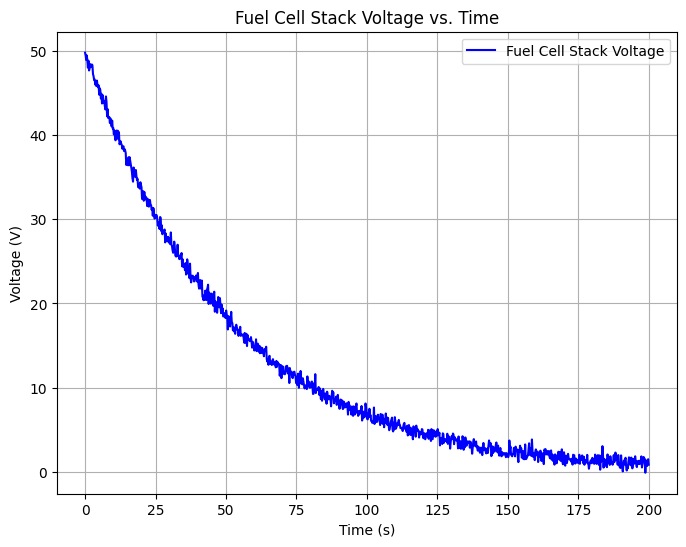

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for synthetic data
t = np.linspace(0, 200, 1000)  # Time array (0 to 100 seconds)
nominal_voltage = 50  # Initial stack voltage (V)
decay_rate = 0.02  # Exponential decay rate
noise_amplitude = 0.5  # Amplitude of random noise

# Generate synthetic voltage data
voltage = nominal_voltage * np.exp(-decay_rate * t) + noise_amplitude * np.random.normal(0, 1, t.size)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(t, voltage, 'b-', label='Fuel Cell Stack Voltage')
plt.title('Fuel Cell Stack Voltage vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

In [2]:
# Normalize voltage to range [0, 1] for ML compatibility
voltage_norm = (voltage - voltage.min()) / (voltage.max() - voltage.min())

# Split the data
n = len(voltage_norm)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_data_raw = voltage_norm[:train_end]
val_data_raw = voltage_norm[train_end:val_end]
test_data_raw = voltage_norm[val_end:]

In [3]:
import tensorflow as tf

# Reshape for TensorFlow: each data point as (value,) instead of flat array
train_data = tf.convert_to_tensor(train_data_raw.reshape(-1, 1), dtype=tf.float32)
val_data = tf.convert_to_tensor(val_data_raw.reshape(-1, 1), dtype=tf.float32)
test_data = tf.convert_to_tensor(test_data_raw.reshape(-1, 1), dtype=tf.float32)


In [4]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data)).batch(batch_size)


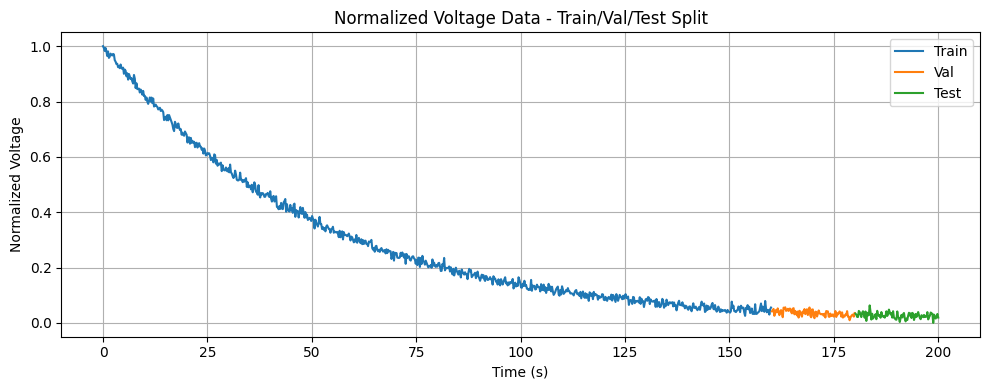

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(t[:train_end], train_data_raw, label="Train")
plt.plot(t[train_end:val_end], val_data_raw, label="Val")
plt.plot(t[val_end:], test_data_raw, label="Test")
plt.title("Normalized Voltage Data - Train/Val/Test Split")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Assuming `train_data_raw`, `val_data_raw`, `test_data_raw` are shape: (num_sequences, 256)

# Reshape to match the Lorenz model expectation: (num_sequences, seq_length, 3)
# Pad with 0s or repeat features to get 3D vector from 1D SoC
def pad_soc_to_3D(data):
    # Here, just repeating SoC value across 3 dims
    return np.repeat(data[..., np.newaxis], 3, axis=-1)

train_data = pad_soc_to_3D(train_data_raw)
val_data = pad_soc_to_3D(val_data_raw)
test_data = pad_soc_to_3D(test_data_raw)

In [7]:
min_val = tf.reduce_min(val_data)
max_val = tf.reduce_max(val_data)

min_train = tf.reduce_min(train_data)
max_train = tf.reduce_max(train_data)

train_data = (train_data - min_train) / (max_train - min_train)
val_data = (val_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)


In [8]:
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# Flatten across time
train_data_flat = tf.reshape(train_data, (-1, 3))  # shape (num_seq * seq_length, 3)
val_data_flat = tf.reshape(val_data, (-1, 3)) 

# Wrap validation in tf.data.Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_data_flat, val_data_flat)).batch(batch_size)

In [10]:
train_data.shape

TensorShape([800, 3])

In [9]:
print(train_data_flat.shape)

(800, 3)


In [39]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout

In [40]:
class EncoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(500, activation="relu")
        self.dense2 = Dense(32, activation="tanh") 
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(0.1) 

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.layer_norm(x)  # Apply LayerNormalization after the dense layer
        x = self.dropout(x)
        return x

In [41]:
# Koopman Layer
class KoopmanLayer(keras.layers.Layer):
    def __init__(self, S):
        super(KoopmanLayer, self).__init__()
        self.S = S

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.K = self.add_weight(
            name="Koopman_weight",
            shape=(latent_dim, latent_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, Z):
        len = tf.shape(Z)[0]
        latent_dim = tf.shape(Z)[1]
        
        # Determine the actual trajectory length to use
        if len > self.S:
            trajLength = self.S
            Z1 = Z[0:trajLength+1]
        else:
            trajLength = len - 1  # Ensure we have room for shifting
            Z1 = Z
        
        # Make sure we don't go out of bounds
        z_shift = Z1[1:trajLength+1, :]
        z_first = Z1[0, :]
        
        # Initialize Z2_tilde with the correct size to match z_shift
        Z2_tilde = tf.zeros([trajLength, latent_dim], dtype=tf.float32)
        
        for m in range(trajLength):
            indices = tf.constant([[m]])
            if m == 0:
                updates = [tf.linalg.matvec(self.K, z_first)]
            else:
                updates = [tf.linalg.matvec(self.K, z_shift[m-1, :])]
            
            Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
        
        return Z1, Z2_tilde, z_shift

# Koopman Model
class KoopmanModel(keras.Model):
    def __init__(self, S):
        super(KoopmanModel, self).__init__()
        self.koopman = KoopmanLayer(S)

    def call(self, z):
        z, Z2_tilde, z_shift = self.koopman(z) 
        
        #z: Latent variables of x in the lifted space
        #z2_tilde: Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
        return z,Z2_tilde,z_shift  # Pass only transformed output to the decoder

In [42]:
class DecoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(500, activation="relu")
        self.output_layer = Dense(3)  

    def call(self, input1, input2):
        z = input1
        z2_tilde = input2
        
        x = self.dense(z)
        x2 = self.dense(z2_tilde)

        return self.output_layer(x), self.output_layer(x2)

In [43]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, S, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = KoopmanModel(S)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde, z2 = self.koopman(z)
        x_hat, x2_tilde = self.dec(z, z2_tilde)
        return x_hat, x2_tilde


In [44]:
import time

class MyStaticModel():
    def __init__(self, input_dim, batch_size, S, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.S = S
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        
    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, model, x, x_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha1 = 1.0
        alpha2 = 10.0
        alpha3 = 1e-6
        
        x2 = x[1:self.S+1]
        
        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        # recon_loss = tf.reduce_mean(tf.abs(tf.subtract(x, x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))
        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])
        
        return alpha1*recon_loss + alpha2*predict_loss + alpha3*lossL2
    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 10  
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        start_time_total = time.time()
        for epoch in range(epochs):
                
            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            epoch_train_min_loss = []
            epoch_train_max_loss = []
            epoch_validation_min_loss = []
            epoch_validation_max_loss = []

            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                
                with tf.GradientTape() as tape:
                    reconstruction, linearity= model(x_batch_train)
                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, linearity_val= model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))

        print("Total time taken: %.2fs" % (time.time() - start_time_total))



In [45]:
train_data_flat

<tf.Tensor: shape=(800, 3), dtype=float32, numpy=
array([[1.        , 1.        , 1.        ],
       [0.9880553 , 0.9880553 , 0.9880553 ],
       [0.9982549 , 0.9982549 , 0.9982549 ],
       ...,
       [0.02372477, 0.02372477, 0.02372477],
       [0.00254104, 0.00254104, 0.00254104],
       [0.0306754 , 0.0306754 , 0.0306754 ]], dtype=float32)>

In [46]:
# Constants
trajLength = 256
numTraj = train_data.shape[0]
numTraj_val = val_data.shape[0]

num_batches_train = int(trajLength * numTraj / batch_size)
num_batches_val = int(trajLength * numTraj_val / batch_size)

S = 255  # One less than trajLength


In [47]:
trajLength

256

In [48]:
num_batches_train

800

In [49]:
num_batches_val

100

In [50]:
train_data_flat.shape

TensorShape([800, 3])

In [51]:
batch_size

256

In [52]:

# Initialize and train
Training_class = MyStaticModel(input_dim=3, batch_size=batch_size, S=S,
                               num_batches_train=num_batches_train,
                               num_batches_val=num_batches_val)

koopmanAEModel = Koopman_AE_Model(S)
Training_class.fit(koopmanAEModel, x=train_data_flat, y=train_data_flat, validation_data=val_dataset, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.0057338
Epoch val loss: 0.022841534614562987
Time taken: 1.58s

Start of epoch 1
Average training loss at epoch 1: 0.0048503
Epoch val loss: 0.019670370817184448
Time taken: 3.07s

Start of epoch 2
Average training loss at epoch 2: 0.0041891
Epoch val loss: 0.016897177696228026
Time taken: 4.50s

Start of epoch 3
Average training loss at epoch 3: 0.0036189
Epoch val loss: 0.014413751363754272
Time taken: 5.98s

Start of epoch 4
Average training loss at epoch 4: 0.0031170
Epoch val loss: 0.012189360857009888
Time taken: 7.44s

Start of epoch 5
Average training loss at epoch 5: 0.0026747
Epoch val loss: 0.010329490900039673
Time taken: 8.96s

Start of epoch 6
Average training loss at epoch 6: 0.0023081
Epoch val loss: 0.008810184597969055
Time taken: 10.52s

Start of epoch 7
Average training loss at epoch 7: 0.0020121
Epoch val loss: 0.007567676901817322
Time taken: 12.09s

Start of epoch 8
Average training loss at epoch 8: 0.0017678


In [53]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[array([[-0.04575775,  0.08939742, -0.03919983, ..., -0.01472683,
         0.07291358, -0.01485697],
       [-0.03111902, -0.05021312, -0.02753797, ...,  0.08837257,
        -0.02742957,  0.0228526 ],
       [ 0.04503641,  0.00257303, -0.03551054, ..., -0.10464421,
        -0.08420766, -0.00141542],
       ...,
       [ 0.00299717,  0.08300431,  0.00788297, ...,  0.01106305,
        -0.01223427, -0.00856869],
       [ 0.02782699, -0.01617647,  0.0385095 , ...,  0.03500333,
         0.00954392, -0.07925145],
       [-0.04113159, -0.06851513, -0.00925911, ..., -0.02280682,
        -0.02449035, -0.02532282]], dtype=float32)]


In [54]:
test_data

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 0.2424485 ,  0.2424485 ,  0.2424485 ],
       [ 0.2608906 ,  0.2608906 ,  0.2608906 ],
       [ 0.46679804,  0.46679804,  0.46679804],
       [ 0.47729364,  0.47729364,  0.47729364],
       [ 0.3022012 ,  0.3022012 ,  0.3022012 ],
       [ 0.29691613,  0.29691613,  0.29691613],
       [ 0.41625783,  0.41625783,  0.41625783],
       [ 0.36580172,  0.36580172,  0.36580172],
       [ 0.16645482,  0.16645482,  0.16645482],
       [ 0.30714473,  0.30714473,  0.30714473],
       [ 0.2426378 ,  0.2426378 ,  0.2426378 ],
       [ 0.43705693,  0.43705693,  0.43705693],
       [ 0.47468704,  0.47468704,  0.47468704],
       [ 0.32744592,  0.32744592,  0.32744592],
       [ 0.2524563 ,  0.2524563 ,  0.2524563 ],
       [ 0.20220196,  0.20220196,  0.20220196],
       [ 0.37883624,  0.37883624,  0.37883624],
       [ 0.2443455 ,  0.2443455 ,  0.2443455 ],
       [-0.13540243, -0.13540243, -0.13540243],
       [ 0.2960787 ,  0.2960787 ,  0.2

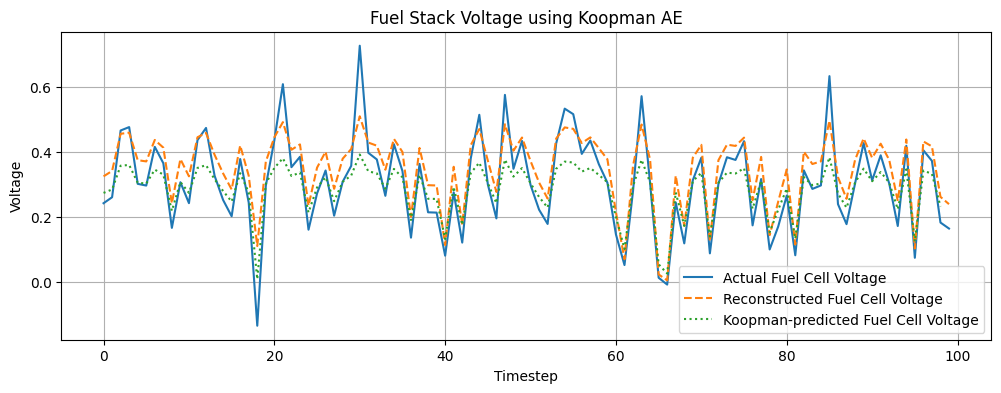

In [55]:
test_data_flat = tf.reshape(test_data, (-1, 3))
res = koopmanAEModel(test_data_flat[:batch_size])

# Plot actual vs reconstructed (just first dimension)
plt.figure(figsize=(12, 4))
plt.plot(test_data_flat[:batch_size, 0], label='Actual Fuel Cell Voltage')
plt.plot(res[0][:, 0], label='Reconstructed Fuel Cell Voltage', linestyle='--')
plt.plot(res[1][:, 0], label='Koopman-predicted Fuel Cell Voltage', linestyle=':')
plt.title("Fuel Stack Voltage using Koopman AE")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid(True)
plt.show()
